In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import abspath, join


sns.set_theme(style="whitegrid")
sns.set_palette("Set2")

CRAWL_FOLDER = "../../output/output_detect_1k/"

def read_sites_from_files(file_path):

    sites = set()
    for line in open(file_path, encoding="utf-8"):
        # skip commented and empty lines
        if line.startswith("#") or line.strip() == '':
            continue
        url = line.strip().lower()
        site = url.split("://", 1)[-1]
        sites.add(site)
    return list(sites)

In [2]:
# TODO: duplicate from helpers; import from a common source
OUTPUT_SITE_FILENAMES = [
    "_successful_sites.txt",
    "_failed_navigations_sites.txt",
    "_failed_crawl_sites.txt",
    "_timed_out_sites.txt"
    ]

site_resuls = []
for output_filename in OUTPUT_SITE_FILENAMES:
    status = output_filename.rsplit("_", 1)[0].strip("_")
    sites = read_sites_from_files(join(CRAWL_FOLDER, output_filename))
    site_resuls.extend([(site, status) for site in sites])

# visits dataframe
# each row is a visit to a site, failed or successful
dfv = pd.DataFrame(site_resuls, columns=["site", "status"])
dfv.head()

,site,status
0,tubidy.fun,successful
1,play.google.com,successful
2,weather.com,successful
3,ijavhd.com,successful
4,ru.m.wikipedia.org,successful


<Axes: xlabel='status', ylabel='count'>

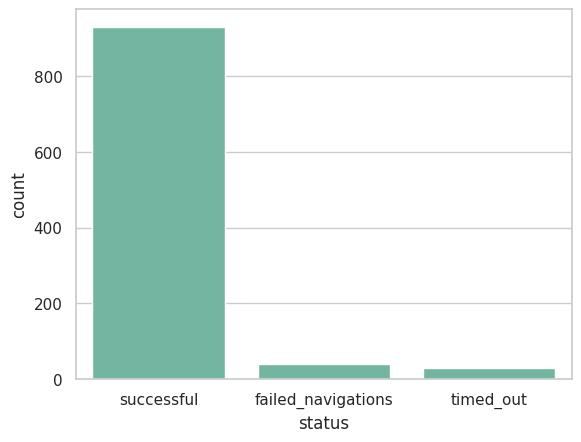

In [3]:
# sns.barplot of number of sites per status
sns.countplot(data=dfv, x="status")

In [4]:
print("Total number of accounted sites: ", len(dfv))


Total number of accounted sites:  1000


In [5]:
results_folder = "results"
version = "0"

In [6]:
def get_crawl_time(general_data):
    start_time = general_data.get("start_time", 0)
    end_time = general_data.get("end_time", 0)

    if start_time == 0 or end_time == 0:
        return None

    return end_time - start_time

def get_has_form(data):
    filled_values = data.get("filled_values", [])
    return len(filled_values) > 0


In [7]:
def read_from_json(json_path):
    with open(json_path, "r") as json_file:
        data = json.load(json_file)
        return data


In [8]:
from tld import get_fld

INPUT_SNIFF_DESC = "Input element value"


def process_input_sniffs(input_sniffs, site, first_submit_timestamp):
    sniff_details = []
    for sniff in input_sniffs:
        if sniff["description"] != INPUT_SNIFF_DESC:
            continue
        script_url = sniff["source"]  # script url of the top call stack frame
        timestamp = sniff["timestamp"]
        # first_submit_timestamp
        if first_submit_timestamp is None:
            pre_submit = False
        else:
            pre_submit = timestamp < (first_submit_timestamp * 1e6)  # convert to microseconds
        field_type = sniff["details"]["type"]
        sniff_value = sniff["details"]["value"]
        base_url = sniff["details"]["baseURI"]  # frame_url or the document url
        sniff_details.append((site, timestamp, field_type, sniff_value, base_url, script_url, pre_submit))
    return sniff_details

## Build the analysis dataframes

In [9]:
# Initialize arrays to store the results
site_results = []
input_sniffs = []

successful_sites = dfv[dfv.status == "successful"].site.values
for site in successful_sites:
    # Load the data from the .json file
    json_path = join(CRAWL_FOLDER, f"{site}.json")
    data = read_from_json(json_path)
    general_data = data.get("general")
    crawl_time = get_crawl_time(general_data)
    n_filled_fields = len(data.get("filled_values", []))
    submit_timestamps = data.get("submit_timestamps", [])
    n_submissions = len(submit_timestamps)
    first_submit_timestamp = submit_timestamps[0] if n_submissions > 0 else None
    cookie_was_accepted = general_data.get("cookie_was_accepted", False)
    api_data = data.get("apis")
    field_sniffs = api_data.get("input_element_results", [])
    input_sniffs.extend(process_input_sniffs(field_sniffs, site, first_submit_timestamp))
    n_field_sniffs = len(field_sniffs)
    # TODO: make sure the call_stats are limited to input element value reads
    sniffer_scripts = api_data.get('call_stats', {}).keys()
    n_sniffer_script_domains = len(set([get_fld(script_url, fix_protocol=True) for script_url in sniffer_scripts]))
    n_saved_calls = len(api_data.get('saved_calls', []))

    n_scripts = len(data.get("scripts", []))
    n_ws_rcvd = len(data.get("websockets", {}).get("received", []))
    n_ws_sent = len(data.get("websockets", {}).get("sent", []))

    # Append the data to the DataFrame
    site_results.append((site, crawl_time, cookie_was_accepted,
                         n_filled_fields, n_submissions, n_field_sniffs,
                         n_sniffer_script_domains, n_saved_calls, n_scripts,
                         n_ws_rcvd, n_ws_sent
                         ))


# sniffs dataframe
# each row is a sniff of an input element value
dfs = pd.DataFrame(columns=["site", "timestamp", "field_type", "value",
                            "base_url", "script_url", "pre_submit"], data=input_sniffs)
dfs['frame_domain'] = dfs.base_url.apply(lambda x: get_fld(x, fix_protocol=True))
dfs['script_domain'] = dfs.script_url.apply(lambda x: get_fld(x, fix_protocol=True))
dfs['tp_frame'] = dfs.site != dfs.frame_domain
dfs['tp_script'] = dfs.site != dfs.script_domain

# site details
# each row is a site with the following details
df = pd.DataFrame(columns=["site", "crawl_time", "cookie_was_accepted",
                           "n_filled_fields", "n_submissions", "n_field_sniffs",
                           "n_sniffer_script_domains", "n_saved_calls", "n_scripts",
                           "n_ws_rcvd", "n_ws_sent"
                           ], data=site_results)
df['has_form'] = df.n_filled_fields > 0
df['has_ws'] = (df.n_ws_rcvd > 0) | (df.n_ws_sent > 0)
df.head()

,site,crawl_time,cookie_was_accepted,n_filled_fields,n_submissions,n_field_sniffs,n_sniffer_script_domains,n_saved_calls,n_scripts,n_ws_rcvd,n_ws_sent,has_form,has_ws
0,tubidy.fun,44.289650,False,2,1,0,1,0,0,0,0,True,False
1,play.google.com,13.041083,False,0,0,0,1,0,0,0,0,False,False
2,weather.com,10.517203,False,0,0,0,1,0,0,0,0,False,False
3,ijavhd.com,7.904778,False,0,0,0,0,0,0,0,0,False,False
4,ru.m.wikipedia.org,23.167623,False,1,1,0,1,0,0,0,0,True,False


In [10]:
dfs.head(3)

,site,timestamp,field_type,value,base_url,script_url,pre_submit,frame_domain,script_domain,tp_frame,tp_script
0,ita.xhamster.com,1731097680384,email,t,https://accounts.google.com/v3/signin/,https://www.gstatic.com/_/mss/boq-identity/_/j...,True,google.com,gstatic.com,True,True
1,ita.xhamster.com,1731097680385,email,t,https://accounts.google.com/v3/signin/,https://www.gstatic.com/_/mss/boq-identity/_/j...,True,google.com,gstatic.com,True,True
2,ita.xhamster.com,1731097681372,email,te,https://accounts.google.com/v3/signin/,https://www.gstatic.com/_/mss/boq-identity/_/j...,True,google.com,gstatic.com,True,True


In [11]:
df.describe()

,crawl_time,n_filled_fields,n_submissions,n_field_sniffs,n_sniffer_script_domains,n_saved_calls,n_scripts,n_ws_rcvd,n_ws_sent
count,930.000000,930.000000,930.000000,930.000000,930.000000,930.0,930.0,930.000000,930.000000
mean,48.189729,0.983871,0.639785,50.665591,1.181720,0.0,0.0,1.473118,0.733333
std,44.492745,1.664147,0.995322,225.448179,1.031417,0.0,0.0,18.939136,7.578216
min,6.436029,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
25%,13.938926,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
50%,29.149693,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000
75%,71.230014,2.000000,1.000000,5.000000,2.000000,0.0,0.0,0.000000,0.000000
max,212.766560,8.000000,3.000000,4673.000000,6.000000,0.0,0.0,526.000000,152.000000


## Timing results

In [12]:
results = {
    "count_crawl": len(df),
    "count_form": len(df[df.has_form]),
    "count_no_form": len(df[~df.has_form]),
    "count_sniffs": len(df[df.has_ws]),  # no of sites with one or more sniffed fields
    "count_ws": len(df[df.n_ws_rcvd > 0]),  # no of sites with one or more sniffed fields
    "avg_crawl_time": df.crawl_time.mean(),
    "avg_form_time": df[df.has_form].crawl_time.mean(),
    "avg_no_form_time": df[~df.has_form].crawl_time.mean(),
    "99th_percentile_crawl": df.crawl_time.quantile(0.99),
    "99th_percentile_form": df[df.has_form].crawl_time.quantile(0.99),
    "99th_percentile_no_form": df[~df.has_form].crawl_time.quantile(0.99),
    "max_crawl_time": df["crawl_time"].max(),
    "max_form_time": df[df.has_form]["crawl_time"].max(),
    "max_no_form_time": df[~df.has_form]["crawl_time"].max()
}

print("Results")
results


Results


{'count_crawl': 930,
 'count_form': 321,
 'count_no_form': 609,
 'count_sniffs': 55,
 'count_ws': 51,
 'avg_crawl_time': 48.18972946418229,
 'avg_form_time': 88.62648680945424,
 'avg_no_form_time': 26.87577362209314,
 '99th_percentile_crawl': 183.72347835540774,
 '99th_percentile_form': 207.20944266319276,
 '99th_percentile_no_form': 128.83453491210926,
 'max_crawl_time': 212.76656007766724,
 'max_form_time': 212.76656007766724,
 'max_no_form_time': 212.04803919792175}

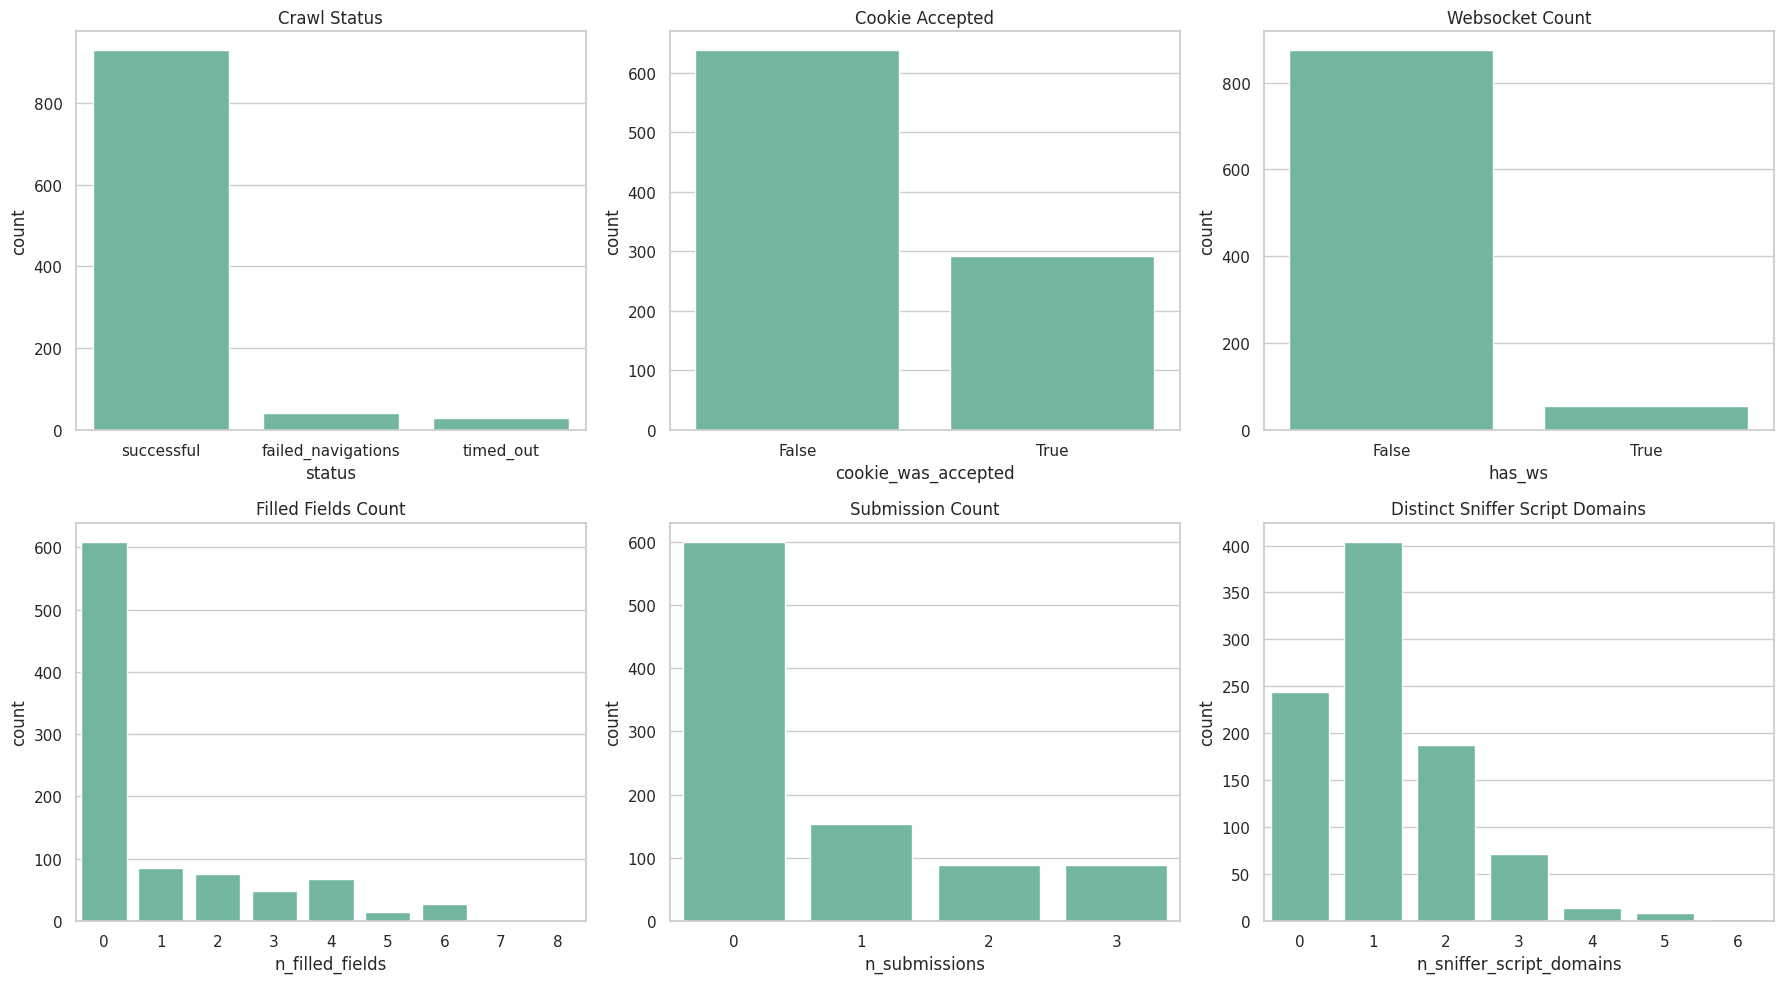

In [13]:
# 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.countplot(data=dfv, x="status", ax=axes[0, 0])
axes[0, 0].set_title('Crawl Status')

sns.countplot(data=df, x="cookie_was_accepted", ax=axes[0, 1])
axes[0, 1].set_title('Cookie Accepted')

sns.countplot(data=df, x="has_ws", ax=axes[0, 2])
axes[0, 2].set_title('Websocket Count')

sns.countplot(data=df, x="n_filled_fields", ax=axes[1, 0])
axes[1, 0].set_title('Filled Fields Count')

sns.countplot(data=df, x="n_submissions", ax=axes[1, 1])
axes[1, 1].set_title('Submission Count')

sns.countplot(data=df, x="n_sniffer_script_domains", ax=axes[1, 2])
axes[1, 2].set_title('Distinct Sniffer Script Domains')

plt.tight_layout()
plt.show()

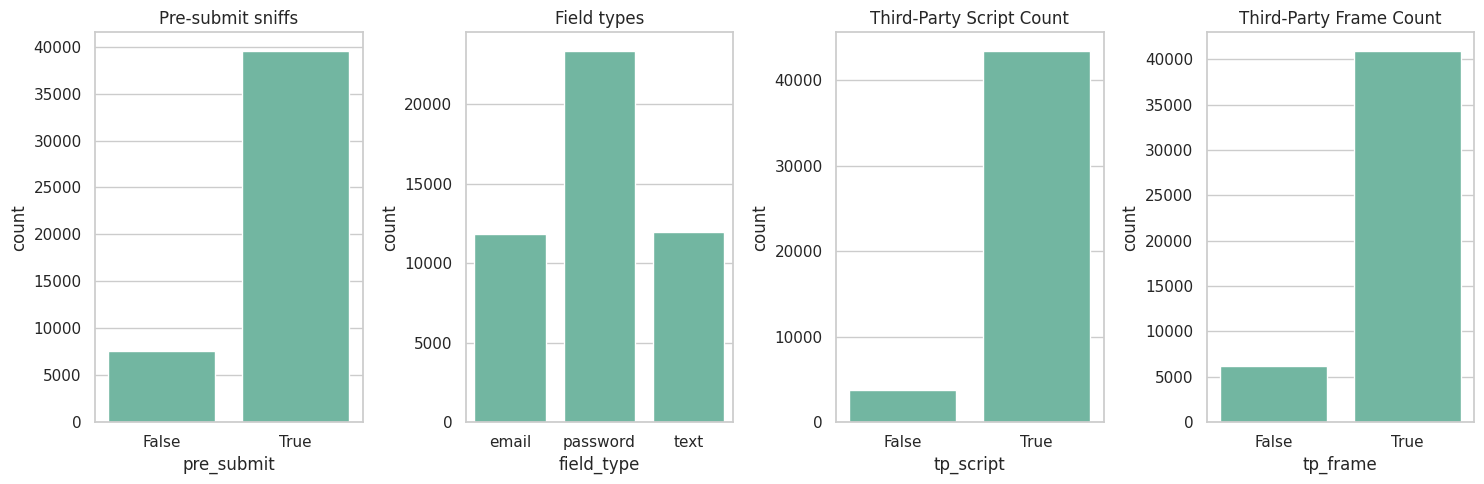

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

sns.countplot(data=dfs, x="pre_submit", ax=axes[0])
axes[0].set_title("Pre-submit sniffs")

sns.countplot(data=dfs, x="field_type", ax=axes[1])
axes[1].set_title("Field types")

sns.countplot(data=dfs, x="tp_script", ax=axes[2])
axes[2].set_title('Third-Party Script Count')

sns.countplot(data=dfs, x="tp_frame", ax=axes[3])
axes[3].set_title('Third-Party Frame Count')

plt.tight_layout()
plt.show()

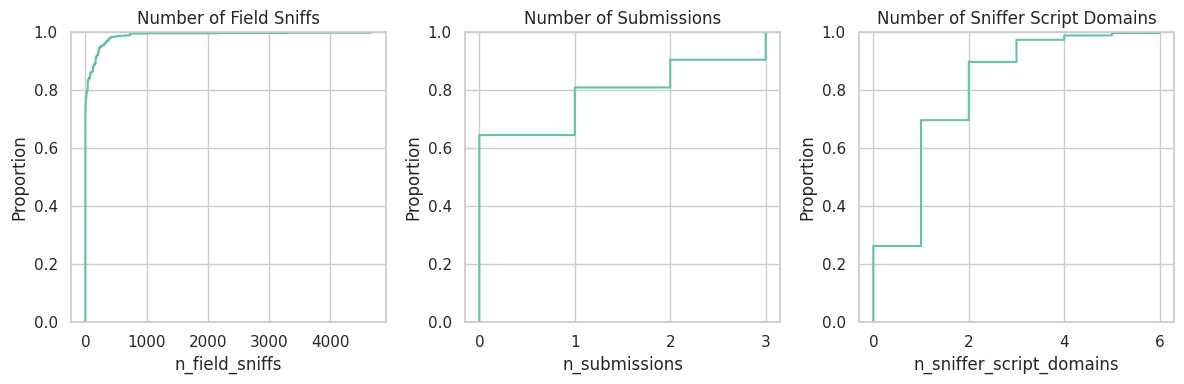

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.ecdfplot(data=df, x="n_field_sniffs", ax=axes[0])
axes[0].set_title('Number of Field Sniffs')

sns.ecdfplot(data=df, x="n_submissions", ax=axes[1])
axes[1].set_title('Number of Submissions')

sns.ecdfplot(data=df, x="n_sniffer_script_domains", ax=axes[2])
axes[2].set_title('Number of Sniffer Script Domains')
plt.tight_layout()
plt.show()

## Crawl Duration - Distribution

<Axes: ylabel='crawl_time'>

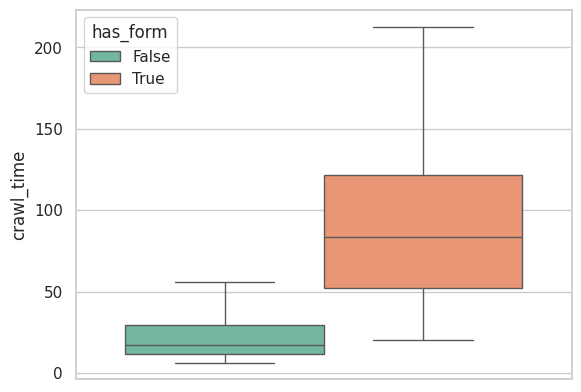

In [16]:
sns.boxplot(data=df, y="crawl_time", hue="has_form", showfliers=False)

<Axes: >

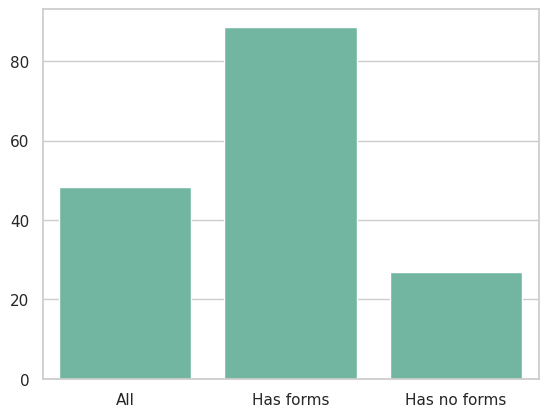

In [17]:
sns.barplot(x=["All", "Has forms", "Has no forms"],
            y=[results["avg_crawl_time"], results["avg_form_time"], results["avg_no_form_time"]])

## Top Sniffers

In [18]:
# no of sites where one or more *password* fields were sniffed by a third-party script
dfs[(dfs.field_type == 'password') & dfs.tp_script].site.nunique()

160

In [19]:
# no of sites where one or more *email* fields were sniffed by a third-party script
dfs[(dfs.field_type == 'email') & dfs.tp_script].site.nunique()

127

In [20]:
dfs[(dfs.field_type == 'password') & dfs.tp_script].groupby('script_domain').site.nunique().sort_values(ascending=False).head(10)

script_domain
gstatic.com            53
xhcdn.com              22
phncdn.com             13
xvideos-cdn.com         7
naver.com               7
fbcdn.net               5
clarity.ms              4
ajax.googleapis.com     3
alicdn.com              3
redditstatic.com        3
Name: site, dtype: int64

In [21]:
dfs[(dfs.field_type == 'email') & dfs.tp_script].groupby('script_domain').site.nunique().sort_values(ascending=False).head(10)

script_domain
gstatic.com              75
ssl-images-amazon.com    10
xvideos-cdn.com           7
clarity.ms                4
contentsquare.net         3
dpgmedia.nl               2
googletagmanager.com      2
msftauth.net              2
ajax.googleapis.com       2
amazon.com                2
Name: site, dtype: int64

In [22]:
dfs.value.value_counts().head(5)

value
TestPass4Sites!         8744
testmail@testing.com    3019
t                       1125
testmail@testing.co     1109
test                    1103
Name: count, dtype: int64

In [23]:
df.to_csv(join(results_folder, f"crawl_results_{version}.csv"), index=False, encoding="utf-8")
dfs.to_csv(join(results_folder, f"sniff_results_{version}.csv"), index=False, encoding="utf-8")